# 1.Librerias

Lo primero que debemos hacer es importar todas las librerías necesarias para llevar a cabo el proyecto. Se ha de destacar que para la correcta ejecución de este notebook, es necesario usar la versión 1.14.0 de tensorflow. 
También es muy interesante configurar el entorno de manera que puedan usarse las GPUs que Google nos proporciona.


In [1]:
# Si hay algun problema en la ejecución, se deberá desinstalar la versión 2.0.0 de 
# tensorflow e instalar la 1.14.0. y poteriormente reiniciar el entorno de ejecución 
%tensorflow_version 2.x
!pip uninstall -y tensorflow
!pip install tensorflow==1.14.0
!pip install tensorflow-gpu==1.14.0

import tensorflow as tf
print(tf.__version__)

if tf.test.gpu_device_name():
   print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Uninstalling tensorflow-1.14.0:
  Successfully uninstalled tensorflow-1.14.0
  Using cached https://files.pythonhosted.org/packages/de/f0/96fb2e0412ae9692dbf400e5b04432885f677ad6241c088ccc5fe7724d69/tensorflow-1.14.0-cp36-cp36m-manylinux1_x86_64.whl


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

1.14.0
Please install GPU version of TF


/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib.pyplot import imshow
from datetime import datetime
from google.colab import drive

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras import optimizers
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


# 2.Funciones generales

A lo largo del proyecto, la métrica que vamos a usar para cuantificar si somos capaces de superar el baseline impuesto (4.8) es la raíz del error cuadrático medio. Por tanto, definiremos ahora una función y la reutilizaremos en repetidas ocasiones.

También vamos a definir otra función con la que graficaremos la evolución del error cometido tanto para el conjunto de entrenamiento como para el de validación.

In [0]:
# RMSE
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Plot history
def plot_history(history):
    plt.figure(figsize=(10,5))
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.plot(history.epoch, 
             np.array(history.history['root_mean_squared_error']),
             label='Train Loss')
    plt.plot(history.epoch, 
             np.array(history.history['val_root_mean_squared_error']),
             label='Validation Loss')
    plt.legend()
    plt.show()


# 3.Preparación de los datos

En este ejercicio vamos a utilizar un conjunto de datos denominado **UNIMIB2016** que está compuesto por 1027 imágenes que contienen platos de comida. Se trata de imágenes en color, con dimensiones espaciales 640 × 480 y cuya etiqueta se corresponde con el porcentaje de píxeles que hacen referencia a la comida dentro de la imagen.

Montamos el Google Drive en el directorio del proyecto y descomprimios el fichero con los datos.


In [0]:

#drive.mount('/content/gdrive')
!unzip -n '/content/DL_UNIMIB2016.zip' >> /dev/null


Definimos las rutas donde hemos situado los datos

In [0]:
# Paths
data_path = 'UNIMIB2016/'
imgs_path = data_path + "images/"
labels_path = data_path + "percentage.csv"

## 3.1. Exploración y preparación del conjunto de etiquetas

Cargamos el fichero de etiquetas y hacemos un análisis exploratorio rápido para ver que es lo que contiene dicho archivo.

En primer lugar, mostramos la cabecera de los datos para ver que efectivamente contamos con dos columnas, una que nos indica el nombre de la imagen y otra el porcentaje de píxeles que ocupa la comida dentro de la imagen. Además, no está de más comprobar que no tengamos porcentajes inferiores al 0% o superiores al 100%, ya que de ser así, tendríamos que desechar dichos registros por ser anómalos. 

La mejor forma de ver esto rápidamente es mediante el uso de un histograma.

In [6]:
labels = pd.read_csv(labels_path)

print("\nNumber of rows: {}".format(labels.shape[0]))
print("Number of columns: {}\n".format(labels.shape[1]))

labels.head(5)


Number of rows: 1027
Number of columns: 2



,image_name,food_pixels
0,20151127_114556.jpg,8.847947
1,20151127_114946.jpg,20.754738
2,20151127_115133.jpg,13.383787
3,20151127_115151.jpg,16.034561
4,20151127_115229.jpg,17.368320


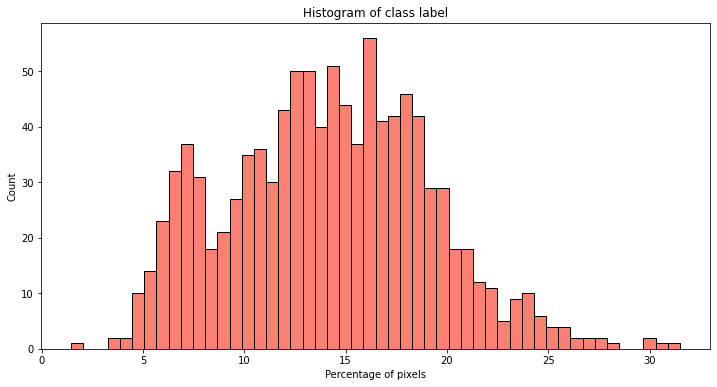

In [7]:
# Plot histogram
plt.figure(figsize=(12,6))
plt.hist(labels.food_pixels, bins=50, color='salmon', edgecolor = 'black')
plt.ylabel("Count")
plt.xlabel("Percentage of pixels")
plt.title("Histogram of class label")
plt.show()

## 3.2. Exploración y preparación de de imágenes

Tras haber visto que los datos contenidos en el fichero de etiquetas, a priori son correctos, veamos ahora alguna de las imágenes.



Shape for image 10: (480, 640, 3)
Percentage of pixeles with food: 16.17%


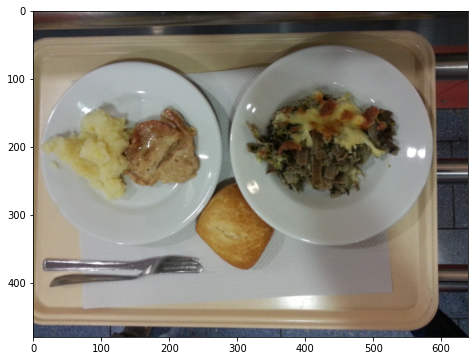

In [8]:
# Load image
image_num = 10
data = image.imread("./UNIMIB2016/images/{}".format(labels.image_name[image_num]))

# Size and label
print("Shape for image {}: {}".format(image_num, data.shape))
print("Percentage of pixeles with food: {:.2f}%".format(labels.food_pixels[image_num]))

# Plot image
plt.figure(figsize=(12,6))
imshow(data)
plt.show()

En este momento, vamos a proceder a dividir el dataset en 3 conjuntos. Uno de ellos será el dataset de entrenamiento, el cual contendrá el 70% de los registros. Otro el que usaremos para llevar a cabo la validación, y pesará el 15% de los registros. Y por último, el conjunto de test estará formado por el 15% restante.

Para mantener la reproducibilidad de los datos también vamos a definir una semilla. 

In [7]:
# Split dataset into: train, validation and test
seed = 0
train_data, test_data = train_test_split(labels, test_size=0.3, random_state=seed)
dev_data, test_data = train_test_split(test_data, test_size=0.5, random_state=seed)

# Update index
train_data = train_data.reset_index(drop=True)
dev_data = dev_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

print("Train data shape: {}".format(train_data.shape))
print("Validation data shape: {}".format(dev_data.shape))
print("Test data shape: {}".format(test_data.shape))

Train data shape: (718, 2)
Validation data shape: (154, 2)
Test data shape: (155, 2)


Ahora sería el turno de cargar las imágenes, sin embargo como no solo vamos a realizar un modelo, probaremos diferentes configuraciones adecuadas a cada red que implementemos. 

La funcion definida en Keras encargada de realizar la generación de las imágenes es ImagedataGenerator, a la que siempre impondremos que reescale las imágenes en el intervalo [0,1] y en alguna ocasión, incluiremos otros parámetros adicionales que nos permitirán realizar *Data Augmentation*.

# 4.Creación del modelo

## 4.1.Arquitectura ad-hoc


La primera red convolucional la diseñaremos nosotros mismos. Sin embargo, antes de comenzar a implementar el modelo debemos llevar a cabo la preparación de las imágenes.

Para este primer caso, vamos a cargar las imágenes con el tamaño que vienen por defecto y usando un batch de 1 imagen. Ademas, a la hora de llamar la función *flow_from_dataframe()* vamos a decirle que no hay un número determinado de clases utilizando el párametro *class_mode='other'*.


In [8]:
# Rescale the images
datagen = ImageDataGenerator(rescale=1./255)

# Main parameters for loading the images
img_width = 640
img_height = 480
x_col = 'image_name'
y_col = 'food_pixels'

#  Generating batches for every partition
batch_size = 1
train_generator = datagen.flow_from_dataframe(dataframe=train_data, 
                                              directory=imgs_path, 
                                              x_col=x_col, 
                                              y_col=y_col, 
                                              has_ext=True,
                                              class_mode="other", 
                                              target_size=(img_width, img_height), 
                                              batch_size=batch_size)

dev_generator = datagen.flow_from_dataframe(dataframe=dev_data, 
                                              directory=imgs_path, 
                                              x_col=x_col, 
                                              y_col=y_col, 
                                              has_ext=True,
                                              class_mode="other", 
                                              target_size=(img_width, img_height), 
                                              batch_size=batch_size)

test_generator = datagen.flow_from_dataframe(dataframe=test_data, 
                                              directory=imgs_path, 
                                              x_col=x_col, 
                                              y_col=y_col, 
                                              has_ext=True,
                                              class_mode="other", 
                                              target_size=(img_width, img_height), 
                                              batch_size=batch_size)


Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.



Definiremos el modelo llamando a la función Sequential() e iremos añadiendole diferentes capas.

En nuestro caso, vamos a añadir cuatro bloques formados por una capa convolucional, seguida de una ReLU y finalmente una MaxPooling.
Las capas convolucionales las iremos haciendo cada vez con más filtros para ir aumentando el volumen de activación. En cuando a las pooling, impondremos que el filtro sea de 3x3, para que se reduzca la imágen en no demasiadas capas.

Posteriormente aplanaremos el volumen en un vector aplicando la capa Flatten. 

Para terminar, incluirimos dos capas completamente conectadas. La primera de ellas con 128 neuronas y la ultima, la salida, con una sola. Entre estas dos capas incluiremos un factor de regularización mediante una capa Dropout con un ratio del 50%.


In [10]:
# Initialize the model
model = Sequential()

# Add four block of layers (convolutional-relu-pooling)
model.add(Conv2D(32, 3, activation='relu', input_shape=(img_width,img_height,3)))
model.add(MaxPooling2D(3))

model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D(3))

model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D(3))

model.add(Conv2D(256, 3, activation='relu'))
model.add(MaxPooling2D(3))

# Add flatten layer to convert the volume into array
model.add(Flatten())

# Add two fully connected layers and a regularization dropout
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(1, activation='relu'))

# Plot model
model.name = 'Model ad-hoc'
model.summary()

Model: "Model ad-hoc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 638, 478, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 212, 159, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 210, 157, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 70, 52, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 68, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 22, 16, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 14, 256)      

Una vez definida la arquitectura de la red, debemos compilarla. Tal y como se indica en el enunciado del ejercicio, la métrica que deberemos usar para poder comparar nuestros resultados con el baseline es el RMSE (Definido en el punto 2). Acorde con esta métrica, la función de pérdida que vamos a utilizar es el MSE, que solo se diferencia de la métrica usada en una raíz cuadrada. El otro parámetro que vamos a definir es el optimizador a usar, en este caso Adam con un *learning rate* de $10^{-4}$.

Por otro lado, vamos a generar 100 epochs, es decir, la red recorrerá 100 veces el conjunto de entrenamiento. Asimismo, imponemos que el tamaño del batch sea 1, con lo que los pesos se reajustarán 100$\cdot$ 718= 71800$ veces durante la fase de entrenamiento.



In [11]:
# Compiling
model.compile(loss='mean_squared_error',
              optimizer=optimizers.adam(lr=1e-4),
              metrics=[root_mean_squared_error])

# Training the model
batch_size = 16
start = datetime.now()
history = model.fit_generator(train_generator,
                    epochs=100,
                    verbose=0,
                    steps_per_epoch=len(train_data)/batch_size,
                    validation_data=dev_generator,
                    validation_steps=len(dev_data)/batch_size)
print("Time spent: {}".format(datetime.now()-start))



Time spent: 0:16:15.457733


Grafiquemos cual ha sido el error de entrenamiendo y validación en función de las epocas.

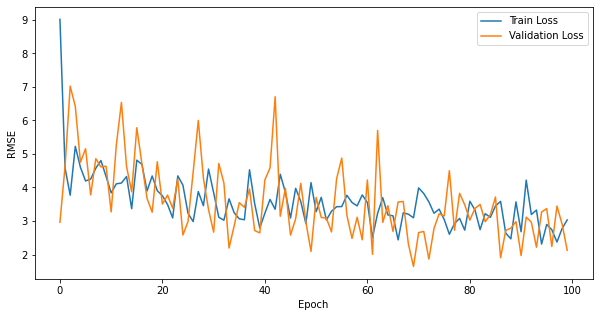

In [12]:
plot_history(history)

Veamos ahora que error comete el model ante nuevas imágenes nunca vistas.

In [13]:
# Evaluating the model
test_loss, test_rmse = model.evaluate_generator(test_generator,
                                               steps=len(test_data)/batch_size,
                                               verbose=1)
print("test_loss: %.4f, test_rmse: %.4f" % (test_loss, test_rmse))

10/9 [==============================] - 1s 65ms/step
test_loss: 7.2119, test_rmse: 2.4270


Parece que nuestro modelo es capaz de superar el baseline que habiamos impuesto. Sin embargo el tiempo que necesitamos para realizar el entrenamiento es

## 4.2.Transfering learning VGG16

El segundo modelo que vamos a probar, no va a ser uno que diseñemos nosotros mismos, si no una red preentrenada con el conjunto de datos ImageNet. A la hora de hacer transfer learning podemos optar por dos opciones: por un lado usar una red preentrenada como extractor de características y modificar las últimas capas(fully-connected) para ajustarlas a nuestro problema, o bien, usar la red completa y hacer fine-tuning de los pesos.
Teniendo en cuenta que el conjunto de datos de ImageNet contiene más de 1 millon de imágenes, y nuestro problema únicamente 1000, vamos a optar por la primera opción, ya que si no podríamos cometer sobreajuste.

La red en cuestión que probaremos será VGG16. Si vamos a la documentación de Keras podemos ver que, a pesar de poder recibir imagenes del tamaño que sea, fue entrenada recibiendo como input imagenes de tamañao 224x224. Por esta razón, vamos a implementar de nuevo ImageDataGenerator con el que, a la hora de generar los conjuntos de entrenamiento, validación y test impongamos que el tamaño de salida de las imagenes sea 224x224.

In [170]:
datagen = ImageDataGenerator(rescale=1./255)

# Resize the images: 224x224
img_width = 224
img_height = 224
x_col = 'image_name'
y_col = 'food_pixels'

batch_size = 16
train_generator = datagen.flow_from_dataframe(dataframe=train_data, 
                                              directory=imgs_path, 
                                              x_col=x_col, 
                                              y_col=y_col, 
                                              has_ext=True,
                                              class_mode="other", 
                                              target_size=(img_width, img_height), 
                                              batch_size=batch_size)

dev_generator = datagen.flow_from_dataframe(dataframe=dev_data, 
                                              directory=imgs_path, 
                                              x_col=x_col, 
                                              y_col=y_col, 
                                              has_ext=True,
                                              class_mode="other", 
                                              target_size=(img_width, img_height), 
                                              batch_size=batch_size)

test_generator = datagen.flow_from_dataframe(dataframe=test_data, 
                                              directory=imgs_path, 
                                              x_col=x_col, 
                                              y_col=y_col, 
                                              has_ext=True,
                                              class_mode="other", 
                                              target_size=(img_width, img_height), 
                                              batch_size=batch_size)

Found 718 validated image filenames.
Found 154 validated image filenames.ERROR! Session/line number was not unique in 
database. History logging moved to new session 64
Found 155 validated image filenames.


Una vez tenemos las imagenes, debemos a cargar la red desde la que haremos transfer learning. Como se ha dicho, imponemos que los pesos sean ajustados con el dataset ImageNet, que la red no nos incluya las capas completamente conectadas de la parte final de la red y definimos el tamaño de las imagenes de entrada.

En este caso, el volumen de activación de la última capa de VGG16 posee una profundidad de 512, por tanto, la primera capa que vamos a añadir a la red es una capa llamada 'GlobalAveragePooling2D' para condensar el volumen de activación en un array con 512 dimensiones. 

Adicionalmente, vamos a incluir al final de la red tres capas completamente conectadas con 512, 256 y 64 neuronas respectivamente. Para evitar el sobreajuste, vamos a incluir una capa Dropout con un ratio del 50%.

Finalmente, añadimos una última capa con una única neurnona, ya que estamos en un problema que solo necesita un número como salida. Como además necesitamos que el output sea estríctamente positivo, incluiremos una función de activación ReLU.



In [171]:
# Load pre-training VGG16 model
base_model = applications.vgg16.VGG16(weights='imagenet', 
                                      include_top=False, 
                                      input_shape=(img_width,img_height,3))


for layer in base_model.layers:
    layer.trainable = False


model = Sequential(layers=[
                           base_model,
                           GlobalAveragePooling2D(),
                           Dense(512, activation='relu'),
                           Dense(256, activation='relu'),
                           Dropout(rate = 0.5),
                           Dense(64, activation='relu'),
                           Dense(1, activation='relu')
                           ])  
model.name = 'Transfer learning - VGG16'          
model.summary()


Model: "Transfer learning - VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_31  (None, 512)               0         
_________________________________________________________________
dense_111 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_112 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_52 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_113 (Dense)            (None, 64)                16448     
_________________________________________________________________
dense_114 (Dense)            (None, 1)   

Como podemos ver, la estructura de nuestro modelo es la red VGG16, más las últimas capas que hemos impuesto nostros mismos. Destacar como el transfer learning nos aporta que, a pesar de haber más de 15 millones de parámetros, nuestra máquina solo tendrá que ajustar entorno a 400.000.

Para compilar el modelo, de nuevo usamos MSE como función de pérdida y RMSE como la metrica. Optimizaremos el modelo usando Adam y el learning rate que nos ha dado buenos resultados para este modelo, $10^{-4}$.

In [0]:
# Complile the model
model.compile(loss='mean_squared_error',
              optimizer=optimizers.adam(lr=1e-4),
              metrics=[root_mean_squared_error])

Llegado este punto, toca entrenar el modelo igual que hicimos antes, pero en este caso solo serán necesarios 30 epochs.

In [175]:
# Train the model
start = datetime.now()
batch_size = 16
history = model.fit_generator(train_generator,
                    epochs=30,
                    verbose=0, #verbose=2,
                    steps_per_epoch=len(train_data)/batch_size,
                    validation_data=dev_generator,
                    validation_steps=len(dev_data)/batch_size)

print("Time spent: {}".format(datetime.now()-start))

Time spent: 0:03:36.838658


Se ha omitido el log que se va generando en cada epoch, por lo que vamos a ver gráficamente los resultados.

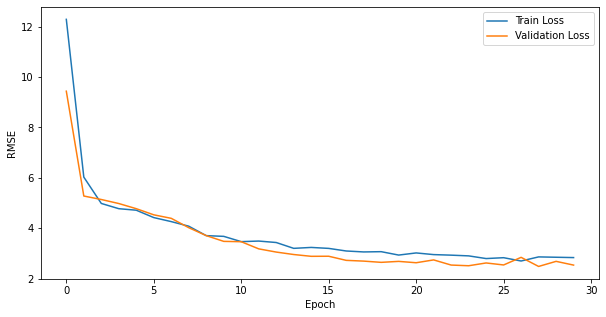

In [176]:
plot_history(history)

Finalmente, validamos el modelo con el conjunto de test.

In [177]:
# Por ultimo, podemos evaluar el modelo en el conjunto de test
test_loss, test_rmse = model.evaluate_generator(test_generator,
                                               steps=len(test_data)/batch_size,
                                               verbose=1)
print("test_loss: %.4f, test_rmse: %.4f" % (test_loss, test_rmse))

10/9 [==============================] - 1s 137ms/step
test_loss: 4.9399, test_rmse: 2.2026


## 4.3. Transfer learning VGG16 - Batch 1


Como tercer modelo, vamos a probar una variación del anterior. En este caso, vamos a seleccionar un batch para el tratamiento de las imagenes de tamaño 1. 

Al modificar el tamaño de los batches, puede darse el caso de cometer sobre ajuste. Para evitar esto, vamos a hacer que el modelo no siempre vea las imagenes en la misma posición, las vamos a rotar aleatoriamente 90º. Además, vamos a realizar un *flip* horizontal.

In [183]:
datagen = ImageDataGenerator(rescale=1./255, 
                             horizontal_flip=True, 
                             rotation_range=90)

img_width = 224
img_height = 224
x_col = 'image_name'
y_col = 'food_pixels'

batch_size = 1
train_generator = datagen.flow_from_dataframe(dataframe=train_data, 
                                              directory=imgs_path, 
                                              x_col=x_col, 
                                              y_col=y_col, 
                                              has_ext=True,
                                              class_mode="other", 
                                              target_size=(img_width, img_height), 
                                              batch_size=batch_size)

dev_generator = datagen.flow_from_dataframe(dataframe=dev_data, 
                                              directory=imgs_path, 
                                              x_col=x_col, 
                                              y_col=y_col, 
                                              has_ext=True,
                                              class_mode="other", 
                                              target_size=(img_width, img_height), 
                                              batch_size=batch_size)

test_generator = datagen.flow_from_dataframe(dataframe=test_data, 
                                              directory=imgs_path, 
                                              x_col=x_col, 
                                              y_col=y_col, 
                                              has_ext=True,
                                              class_mode="other", 
                                              target_size=(img_width, img_height), 
                                              batch_size=batch_size)

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.


Definimos el modelo exactamente igual que antes.

In [184]:
# Load pre-training VGG16 model
base_model = applications.vgg16.VGG16(weights='imagenet', 
                                      include_top=False, 
                                      input_shape=(img_width,img_height,3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential(layers=[
                           base_model,
                           GlobalAveragePooling2D(),
                           Dense(512, activation='relu'),
                           Dense(256, activation='relu'),
                           Dropout(rate = 0.5),
                           Dense(64, activation='relu'),
                           Dense(1, activation='relu')
                           ])  
model.name = 'Transfer learning - VGG16 - Batch 1'          
model.summary()

Model: "Transfer learning - VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_33  (None, 512)               0         
_________________________________________________________________
dense_119 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_120 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_54 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_121 (Dense)            (None, 64)                16448     
_________________________________________________________________
dense_122 (Dense)            (None, 1)   

Compilamos

In [0]:
# Complile the model
model.compile(loss='mean_squared_error',
              optimizer=optimizers.adam(lr=1e-4),
              metrics=[root_mean_squared_error])

Y finalmente entrenamos usando tantos pasos por epoch como imagenes tenemos en el conjunto de datos.

In [186]:
# Entrenamos el modelo con los datos preparados en el punto 2
start = datetime.now()
batch_size = 1
history = model.fit_generator(train_generator,
                    epochs=30,
                    verbose=0,
                    steps_per_epoch=len(train_data)/batch_size,
                    validation_data=dev_generator,
                    validation_steps=len(dev_data)/batch_size)

print("Time spent: {}".format(datetime.now()-start))

Time spent: 0:12:12.102268


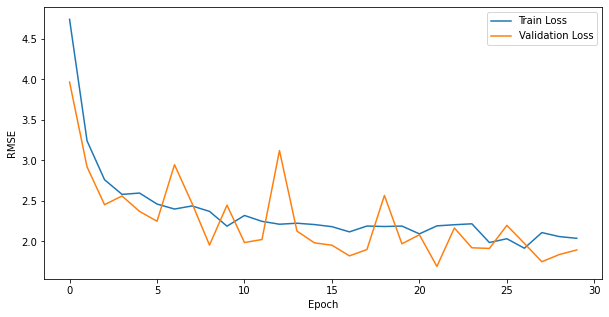

In [187]:
plot_history(history)

In [188]:
# Por ultimo, podemos evaluar el modelo en el conjunto de test
test_loss, test_rmse = model.evaluate_generator(test_generator,
                                               steps=len(test_data)/batch_size,
                                               verbose=1)
print("test_loss: %.4f, test_rmse: %.4f" % (test_loss, test_rmse))

155/155 [==============================] - 4s 28ms/step
test_loss: 3.8819, test_rmse: 1.5470


## 4.4. Transfer learning VGG19

Para finalizar, vamos a probar una variante de VGG16 denominada VGG19. La diferencia entre uno y otro, es que VGG19 cuenta con 3 capas convolucionales más con respecto a VGG16, pero la idea principal de mantener el tamaño de las convoluciones pequeño y conseguir una red profunda, no cambia.

Seráun modelo exactamente igual que el probado en el apartado 4.3.

In [90]:
datagen = ImageDataGenerator(rescale=1./255, 
                             horizontal_flip=True, 
                             rotation_range=90)

# Resize the images: 224x224
img_width = 640
img_height = 480
x_col = 'image_name'
y_col = 'food_pixels'

batch_size = 1
train_generator = datagen.flow_from_dataframe(dataframe=train_data, 
                                              directory=imgs_path, 
                                              x_col=x_col, 
                                              y_col=y_col, 
                                              has_ext=True,
                                              class_mode="other", 
                                              target_size=(img_width, img_height), 
                                              batch_size=batch_size)

dev_generator = datagen.flow_from_dataframe(dataframe=dev_data, 
                                              directory=imgs_path, 
                                              x_col=x_col, 
                                              y_col=y_col, 
                                              has_ext=True,
                                              class_mode="other", 
                                              target_size=(img_width, img_height), 
                                              batch_size=batch_size)

test_generator = datagen.flow_from_dataframe(dataframe=test_data, 
                                              directory=imgs_path, 
                                              x_col=x_col, 
                                              y_col=y_col, 
                                              has_ext=True,
                                              class_mode="other", 
                                              target_size=(img_width, img_height), 
                                              batch_size=batch_size)

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.


In [85]:
# Load pre-training VGG16 model
base_model = applications.vgg19.VGG19(weights='imagenet', 
                                      include_top=False, 
                                      input_shape=(img_width,img_height,3))


for layer in base_model.layers:
    layer.trainable = False


model = Sequential(layers=[
                           base_model,
                           GlobalAveragePooling2D(),
                           Dense(512, activation='relu'),
                           Dense(256, activation='relu'),
                           Dropout(rate = 0.5),
                           Dense(64, activation='relu'),
                           Dense(1, activation='relu')
                           ])  
model.name = 'Transfer learning - VGG19'          
model.summary()


Model: "Transfer learning - VGG19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_63 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_24 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_65 (Dense)             (None, 1)   

In [0]:
# Complile the model
model.compile(loss='mean_squared_error',
              optimizer=optimizers.adam(lr=1e-4),
              metrics=[root_mean_squared_error])

In [87]:
# Entrenamos el modelo con los datos preparados en el punto 2
start = datetime.now()
batch_size = 1
history = model.fit_generator(train_generator,
                    epochs=30,
                    verbose=0,
                    steps_per_epoch=len(train_data)/batch_size,
                    validation_data=dev_generator,
                    validation_steps=len(dev_data)/batch_size)

print("Time spent: {}".format(datetime.now()-start))


Time spent: 0:08:12.188375


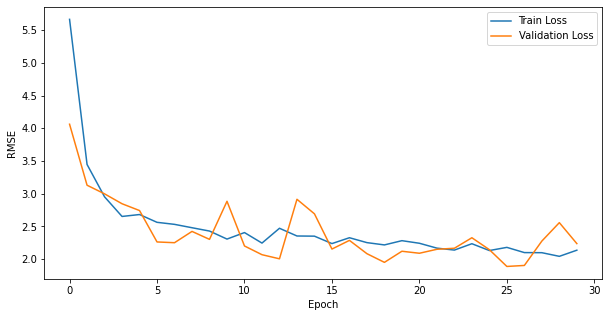

In [88]:
plot_history(history)

In [89]:
# Por ultimo, podemos evaluar el modelo en el conjunto de test
print()
test_loss, test_rmse = model.evaluate_generator(test_generator,
                                               steps=len(test_data)/batch_size,
                                               verbose=1)
print("test_loss: %.4f, test_rmse: %.4f" % (test_loss, test_rmse))


155/155 [==============================] - 3s 20ms/step
test_loss: 6.8404, test_rmse: 2.0482
